In [2]:
%reload_ext autoreload
%autoreload 2
import pyxdf
import os
import numpy as np
from scipy import stats
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
from hampel import hampel
import seaborn
import matplotlib.pyplot as plt
from tueplots import axes, bundles

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w"})
bundles.beamer_moml()

from utilities.utl import find_lsl_stream, find_nearest, fill_nan, get_channel_labels_ppl_xdf
from utilities.pupil_prep import *
from utilities.SingleSubjectData import SubjectData, Epochs



c:\Users\User\anaconda3\envs\venv_tremor_feedback\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [4]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


In [5]:
# set params for epoch processing and plotting
from cProfile import label


cfg_pupil_plot_colors = plt.cm.viridis(np.linspace(0,1,3))
cfg_bl_times = [20,28]
cfg_bl_times.sort()
cfg_trial_times = [35,50]
cfg_trial_times.sort()
cfg_epoch_times =  [-60,0]
cfg_epoch_times.sort()

if np.max(cfg_trial_times) > np.diff(cfg_epoch_times):
    raise ValueError ('Time window of interest ouside epoch length')

# prelocate variables
tmp_fnms = fnms[14:15]
print([f.split('_')[0] for f in tmp_fnms])

id = []
n_trial = []
con_view_ang = []
con_feedback = []
per_bad_samples = []
ppl_size = []



for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    if not sub.eye:
        print(f'No pupil data found for {sub.id}')
        continue

    # extract ppl chn names
    nms_ppl = get_channel_labels_ppl_xdf(sub.eye)

    # epoch data
    eps = Epochs(sub,sub.eye["time_series"],times=sub.eye["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('end_trial', idx_start=idx_exp_start,tmin=cfg_epoch_times[0],tmax=cfg_epoch_times[1])
    eps.data[eps.data == 0] = np.nan

    # prep pupil data
    ch_oi = ['confidence', 'diameter1_3d']
    idx_ch_oi = [nms_ppl.index(key) for key in ch_oi]   

    # prep single trial pupil data
    for i in range(eps.data.shape[2]):

        if 0 <= i < 4:
            tmp_color = cfg_pupil_plot_colors[0]
            tmp_label = 'visual'
        elif 4 <= i < 8:
            tmp_color = cfg_pupil_plot_colors[1] 
            tmp_label = 'auditiv-visual'
        elif 8 <= i <12:
            tmp_color = cfg_pupil_plot_colors[2]
            tmp_label = 'auditiv'      

        id.append(sub.id)
        n_trial.append(i)
        ep = eps.data[idx_ch_oi,:,i]
        ep = pd.DataFrame(ep.T)
        ep.columns = [ch_oi]
        ep = ep.interpolate(method='linear',axis='rows')

        lower_thresh = ep["diameter1_3d"].median(axis=0)-ep["diameter1_3d"].std(axis=0)*1.5
        upper_thresh = ep["diameter1_3d"].median(axis=0)+ep["diameter1_3d"].std(axis=0)*1.5

        idx_bad_samples = np.logical_or(ep.diameter1_3d < lower_thresh,ep.diameter1_3d > upper_thresh)
        per_bad_samples.append(float(idx_bad_samples.sum() / len(idx_bad_samples)))
        ep["diameter1_3d"] = np.where(idx_bad_samples,np.nan,ep.diameter1_3d)
        
        ep = ep.interpolate(method='linear',axis='rows')
        ep["diameter1_3d"] = hampel(ep["diameter1_3d"].squeeze(), window_size=60, n=1, imputation=True).ewm(span = 60).mean()
        ep["diameter1_3d"].ewm(span = 60).mean()

        # do baseline correction
        bl_diam = ep["diameter1_3d"][np.logical_and(eps.times > cfg_bl_times[0],eps.times < cfg_bl_times[1])].mean()
        ep["diameter1_3d"] = ep["diameter1_3d"] - bl_diam
        tmp_pupil_size = ep["diameter1_3d"][np.logical_and(eps.times > cfg_trial_times[0],eps.times < cfg_trial_times[1])].mean()[0]
        ppl_size.append(tmp_pupil_size)

        cfg_plot_lw = .6 
        if per_bad_samples[-1] <= .1:
            cfg_plot_lw = .2

        cfg_epoch_timevec = np.linspace(-30,30,len(eps.times))

        if i in [0,4,8]:
            plt.plot(cfg_epoch_timevec,ep["diameter1_3d"].ewm(span = eps.srate * 2).mean().to_numpy(),color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, label=tmp_label)
        else:
            plt.plot(cfg_epoch_timevec,ep["diameter1_3d"].ewm(span = eps.srate * 2).mean().to_numpy(),color=tmp_color,linewidth=cfg_plot_lw, alpha=.5)

    plt.axvline(0,c='k')
    plt.axvline(-10,c='k',ls = '--', lw = .5)
    plt.axvline(-2,c='k',ls = '--', lw = .5)
    plt.xlabel('Time[s]')
    plt.ylabel('Diameter [mm^2]')
    plt.title(f"{sub.id} pupil epochs")
    plt.legend()
    plt.savefig(Path.joinpath(dir_plots,f"{sub.id}_pupil_epochs.png"))
    plt.clf()

    # info per epoch
    con_view_ang.extend(eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2))
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])




['p203']
Max force is 7724 something for p203


<Figure size 1200x800 with 0 Axes>

In [6]:
timestamps = sub.eye["time_stamps"]
total_time = timestamps[-1] - timestamps[0]


In [8]:
history_length = 0.2
onset_confidence_threshold = 0.5
offset_confidence_threshold = -0.5

# extract ppl chn names
ch_info = sub.eye["info"]["desc"][0]["channels"][0]
nms_ppl = []
for i,ch in enumerate(ch_info["channel"]):
    nms_ppl.append(ch_info["channel"][i].get('label')[0])

In [56]:
idx_ch_oi = 21
idx_ep_oi = 2
activity = eps.data[0,:,idx_ep_oi]
raw = eps.data[idx_ch_oi,:,idx_ep_oi]
timestamps = sub.eye["time_stamps"]
total_time = timestamps[-1] - timestamps[0]
filter_size = 2 * round(len(activity) * history_length / total_time / 2.0)
blink_filter = np.ones(filter_size) / filter_size

In [45]:
eps.data.shape

(22, 14870, 12)

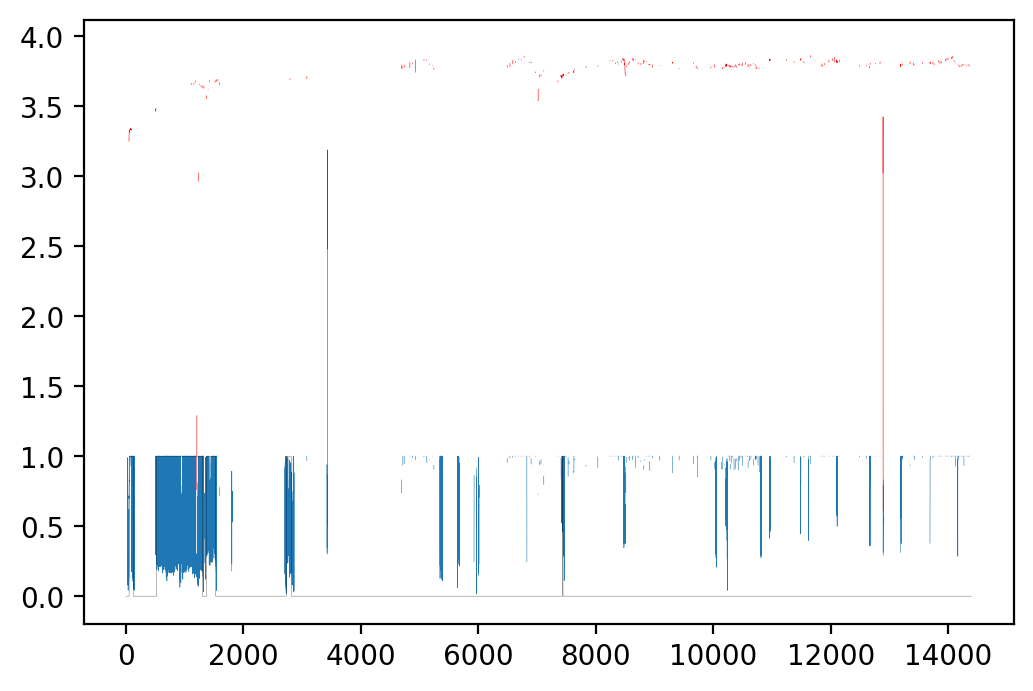

In [13]:
from scipy.signal import convolve, windows

history_length = 0.2
onset_confidence_threshold = 0.5
offset_confidence_threshold = -0.5

# extract ppl chn names
ch_info = sub.eye["info"]["desc"][0]["channels"][0]
nms_ppl = []
for i,ch in enumerate(ch_info["channel"]):
    nms_ppl.append(ch_info["channel"][i].get('label')[0])



idx_ch_oi = 21
idx_ep_oi = 0
activity = eps.data[0,:,idx_ep_oi]
raw = eps.data[idx_ch_oi,:,idx_ep_oi]
timestamps = eps.times
total_time = timestamps[-1] - timestamps[0]
filter_size = 2 * round(len(activity) * history_length / total_time / 2.0)
blink_filter = np.ones(filter_size) / filter_size

# This is different from the online filter. Convolution will flip
# the filter and result in a reverse filter response. Therefore
# we set the first half of the filter to -1 instead of the second
# half such that we get the expected result.
#blink_filter[: filter_size // 2] *= -1

# The theoretical response maximum is +-0.5
# Response of +-0.45 seems sufficient for a confidence of 1.
filter_response = convolve(activity, blink_filter, mode = "same", method = "direct") / 0.45

onsets = filter_response > onset_confidence_threshold
offsets = filter_response < -offset_confidence_threshold

response_classification = np.zeros(filter_response.shape)
response_classification[onsets] = 1.0
response_classification[offsets] = -1.0

plt.clf()
plt.plot(activity,lw=0.2)
plt.plot(response_classification,'k',lw=.1)
plt.plot(raw,'r',lw=0.2)



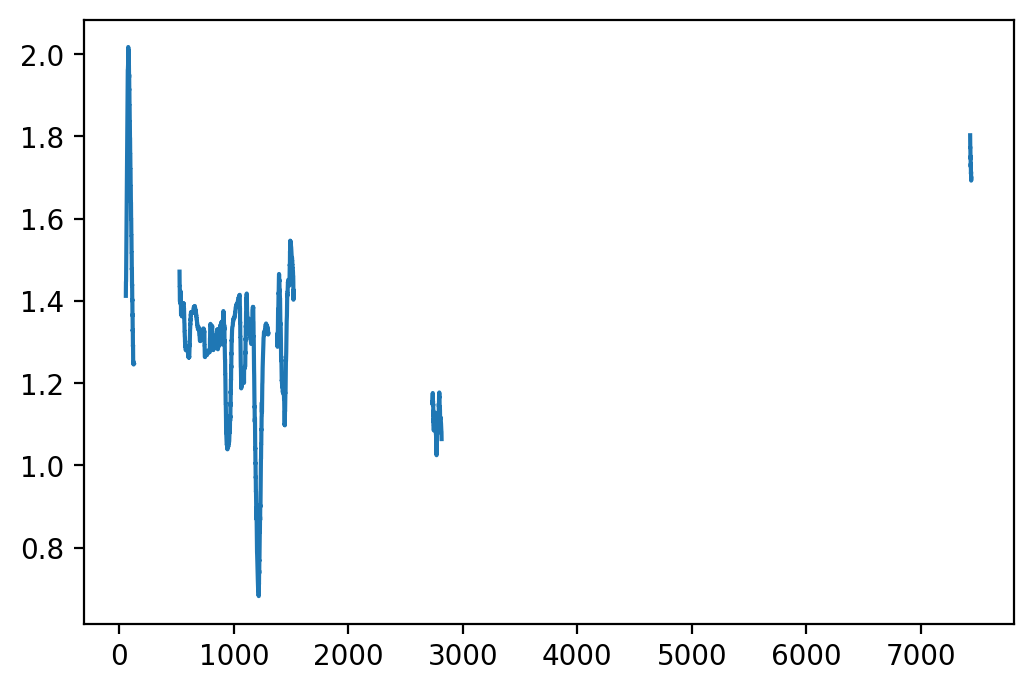

In [14]:
plt.plot(filter_response)

In [18]:
all_trials = {"ID": id, "Trial n": n_trial, "Feedback type": con_feedback, "Feedback angle": con_view_ang, "Pupil size": ppl_size, "Percentage bad pupil samples": per_bad_samples}
all_trials = pd.DataFrame(all_trials)

# convert float to categorical

all_trials["Feedback angle"] = all_trials["Feedback angle"].astype(str).map({'0.02': 'low', '0.44': 'high'})
all_trials["Group"] = all_trials["ID"].str[0]
fname = "all_trials_pupil.csv"

all_trials.to_csv(Path.joinpath(dir_prep,fname))



In [9]:
from scipy.stats import ttest_ind
from scipy import stats
df = all_trials
ppl_z = np.abs(stats.zscore(df['Pupil size']))
df = df[ppl_z <  3]
df_ = df


#define samples
low = df_[df_["Feedback angle"]==0.02]
high = df_[df_["Feedback angle"]==0.44]

#perform independent two sample t-test
t_, p_ = ttest_ind(low['Pupil size'],high['Pupil size'])



Text(0.5, 1.0, 'p:0.002 easy vs. hard')

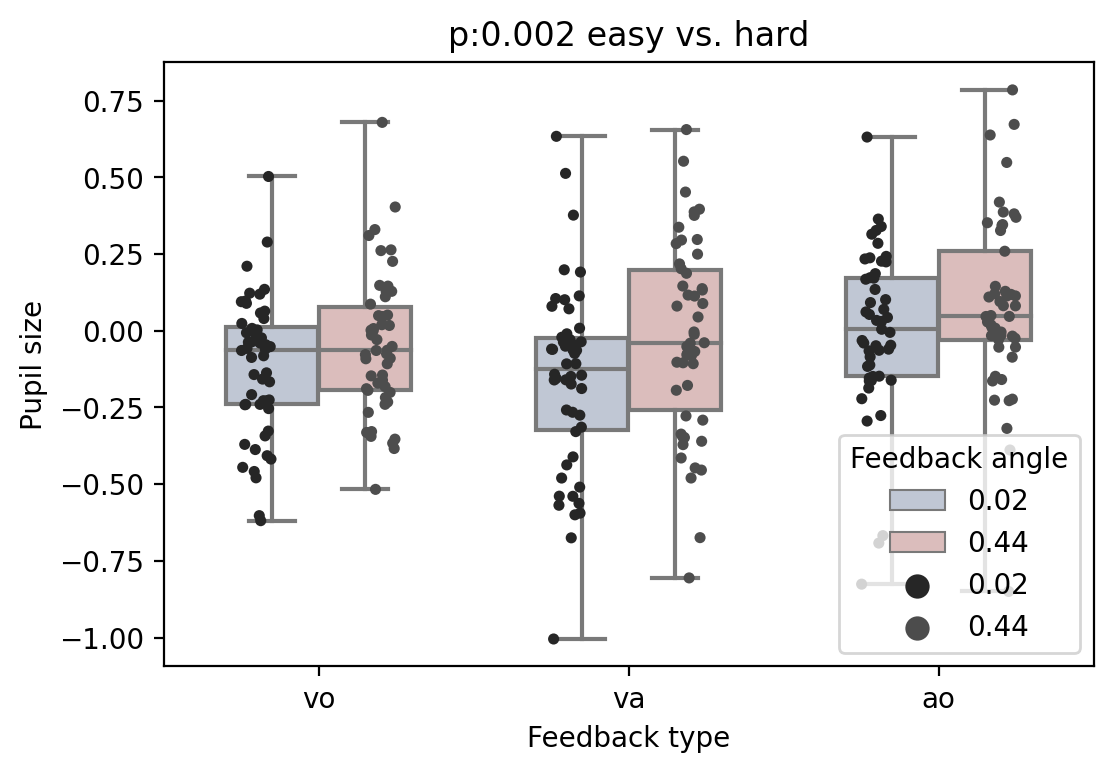

In [10]:
import seaborn as sns

sns.boxplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",size=4, color=".3", linewidth=0,dodge=True)

plt.title(f"p:{round(p_,3)} easy vs. hard")